## Setup and IO

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from PIL import Image

## Support functions

In [2]:
class Plotter(object):
    
    def __init__(self):
        pass
    
    def from_file(self, img):
        img2 = np.array(Image.open(img), dtype=np.uint8)
        fig,ax = plt.subplots(1)
        ax.imshow(img2)
        plt.show()
        
    def img_show_with_box(self, img, bbox):
        img2 = np.array(Image.open(img), dtype=np.uint8)
        fig, ax = plt.subplots(1)
        ax.imshow(img2)
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

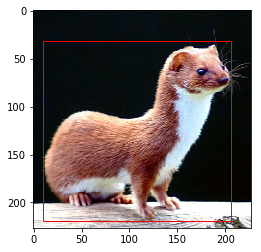

In [3]:
plotter = Plotter()
plotter.img_show_with_box('tmp/training_data/alexnet/laska.png', [10, 32, 196, 187])

In [4]:
class ImageTransformer(object):

    def __init__(self):
        pass

    def get_size(self, img):
        """Accepts fname or cv2 image"""
        # TODO: probably best to avoid the polymorphism
        if type(img)==str:
            return Image.open(img).size
        else:
            return img.size

    def array_to_imgfile(self, array, fname):
        img = Image.fromarray(array)
        img.save(fname)

    def crop_imgfile(self, fname, bbox):
        img = np.array(Image.open(fname), dtype=np.uint8)
        return img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]

    def resize_imgfile(self, fname, size=(227, 227)):
        img = cv2.imread(fname)
        img_resized = cv2.resize(img, size)
        cv2.imwrite(fname, img_resized)

In [5]:
imgTrans = ImageTransformer()
imgTrans.get_size('tmp/training_data/alexnet/laska.png')

(227, 227)

## Super class

In [6]:
class ImageSources(object):
    
    def __init__(self):
        self.delta_mean = 0.0
        self.delta_x_scale = 0.05
        self.delta_y_scale = 0.05
        self.gamma_mean = 1.0
        self.gamma_width_scale = 0.01
        self.gamma_height_scale = 0.01
        self.bbox_scaling = 2.0
        
    # ------------------------------
    #   Box generation
    # ------------------------------
    
    def __offset_box(self, track_box):
        xi = track_box[0] - int(track_box[2] / 2)
        yi = track_box[1] - int(track_box[3] / 2)
        wi = track_box[2] * 2
        hi = track_box[3] * 2        
        return [xi, yi, wi, hi]

    def generate_start_boxes(self, img_size, track_box, samples=10):
        x_old, y_old, width_old, height_old = track_box
        img_width, img_height = img_size
        bboxes = []
        
        for idx in range(samples):
            gamma_width = np.random.laplace(self.gamma_mean, self.gamma_width_scale)
            gamma_height = np.random.laplace(self.gamma_mean, self.gamma_height_scale)
            delta_x = np.random.laplace(self.delta_mean, self.delta_x_scale)
            delta_y = np.random.laplace(self.delta_mean, self.delta_y_scale)

            # No smoothness for first bounding box
            if not idx:
                gamma_width = 1.0
                gamma_height = 1.0
                delta_x = 0.0
                delta_y = 0.0
            
            #print gamma_width, gamma_height, delta_x, delta_y
            width    = self.bbox_scaling * width_old * gamma_width
            height   = self.bbox_scaling * height_old * gamma_height

            x_center = x_old + (width_old * (0.5 + delta_x))
            y_center = y_old + (height_old * (0.5 + delta_y))
            
            x = x_center - (width / 2)
            y = y_center - (height / 2)
            
            # Clip bbox to image after integer conversion
            x_new = max(0, min(int(x), img_width - 1))
            y_new = max(0, min(int(y), img_height - 1))
            width_new = min(int(width), img_width - 1 - x_new)
            height_new = min(int(height), img_height - 1 - y_new)
            
            # Append
            bboxes.append([x_new, y_new, width_new, height_new])
            
        return bboxes

    def generate_next_box(self, img_size, prev_box):
        return prev_box

In [7]:
imgSources = ImageSources()

In [8]:
imgSources.generate_start_boxes([100,100], [20, 20, 10, 10], samples=1)

[[15, 15, 20, 20]]

In [9]:
imgSources.generate_start_boxes([100,100], [5, 20, 10, 10], samples=1)

[[0, 15, 20, 20]]

In [10]:
imgSources.generate_start_boxes([100,100], [95, 20, 10, 10], samples=1)

[[90, 15, 9, 20]]

In [16]:
imgSources.generate_start_boxes((400, 224), [141, 81, 76, 122], samples=1)

[[103, 20, 152, 203]]

## Specific for VOT

In [12]:
class VotDataSource(object):

    def __init__(self, root_dir = 'tmp/training_data/vot'):
        self.root_dir = root_dir
        # only immediate subfolders, http://stackoverflow.com/a/973488/1509221
        self.pjs = sorted(next(os.walk(root_dir))[1])
        #self.pjs = ['ball']

        self.plotter         = Plotter()
        self.img_sources     = ImageSources()
        self.img_transformer = ImageTransformer()

        super(VotDataSource, self).__init__()

    # ------------------------------
    #   Project data extraction
    # ------------------------------

    def __get_project_dir(self, pname):
        return os.path.join(self.root_dir, pname)

    def __get_project_images(self, pname, ext='jpg'):
        dir_project = self.__get_project_dir(pname)
        out = []

        for file in os.listdir(dir_project):
            if file.endswith('.{}'.format(ext)):
                out.append(os.path.join(dir_project, file))

        return sorted(out)

    def __get_project_boxes(self, pname, convert=True):
        dir_project  = self.__get_project_dir(pname)
        file = os.path.join(dir_project, 'groundtruth.txt')
        out  = []

        def __clean(l):
            rect    = [int(float(n)) for n in l.strip().split(',')]

            #xy_wh    = [rect[2], rect[3], rect[4]-rect[2], rect[1]-rect[3]]
            #xy_wh    = [rect[0], rect[1], rect[4]-rect[0], rect[5]-rect[1]]

            xi       = [rect[0], rect[2], rect[4], rect[6]]
            yi       = [rect[1], rect[3], rect[5], rect[7]]
            xy_wh    = [min(xi), min(yi), max(xi)-min(xi), max(yi)-min(yi)]

            if convert:
                return xy_wh
            else:
                return rect

        with open(file, 'r') as f:
            out = [__clean(l) for l in f.readlines()]

        return out

    def __debug_project_image(self, pname, i):
        imgs  = self.__get_project_images(pname)
        boxes = self.__get_project_boxes(pname)

        print(imgs[i])
        print(boxes[i])
        self.plotter.img_show_with_box(imgs[i], boxes[i])

    # ------------------------------
    #   Image conversions
    # ------------------------------

    def __dataframe_out(self, out):
        return pd.DataFrame(out,
                            columns=['file1', 'file2', 'bbtlx', 'bblry', 'bbbrx', 'bbbry'])

    def bootstrap(self, out_dir, stop=10, size=(227, 227), smooth_samples=0):
        os.makedirs(out_dir, exist_ok=True)
        self.counter = 0
        self.running = 0
        out = []

        for pname in self.pjs:
            print('Running: {}'.format(pname))
            imgs  = self.__get_project_images(pname)
            boxes = self.__get_project_boxes(pname)

            # ball contains an extra image that's inconsistent with ball/groundtruth.txt
            if pname == 'ball':
                del imgs[0]
            assert len(imgs) == len(boxes), 'imgs: %d, boxes: %d' % (len(imgs), len(boxes))

            for i in range(len(imgs)-1):
                t0_image       = imgs[i]
                t0_image_size  = self.img_transformer.get_size(t0_image)
                t0_track_box   = boxes[i]
                t0_bound_boxes = self.img_sources.generate_start_boxes(
                    t0_image_size, t0_track_box, samples=1+smooth_samples)

                t1_track_box       = [None, None, None, None]
                t1_bound_rel_coord = [None, None, None, None]

                for t0_bound_box in t0_bound_boxes:
                    try:
                        # Extract and transform the first image
                        crop0 = self.img_transformer.crop_imgfile(t0_image, t0_bound_box)
                        name0 = os.path.join(out_dir, 'img_{}_0.jpg'.format(self.counter))
                        self.img_transformer.array_to_imgfile(crop0, name0)
                        self.img_transformer.resize_imgfile(name0, size=size)

                        t1_img = imgs[i+1]
                        t1_track_box = boxes[i+1]
                        t1_bound_box = t0_bound_box

                        # Define in delta coordinates the final box
                        t1_bound_rel_coord[0] = (t1_track_box[0] - t1_bound_box[0]) * 1.0/t1_bound_box[2]
                        t1_bound_rel_coord[1] = (t1_bound_box[1] - t1_track_box[1]) * 1.0/t1_bound_box[3]                        
                        t1_bound_rel_coord[2] = (t1_bound_rel_coord[0] + t1_track_box[2]) * 1.0/t1_bound_box[2]
                        t1_bound_rel_coord[3] = (t1_bound_rel_coord[1] + t1_track_box[3]) * 1.0/t1_bound_box[3]

                        # Extract and transform the next image
                        crop1 = self.img_transformer.crop_imgfile(t1_img, t1_bound_box)
                        name1 = os.path.join(out_dir, 'img_{}_1.jpg'.format(self.counter))
                        self.img_transformer.array_to_imgfile(crop1, name1)
                        self.img_transformer.resize_imgfile(name1, size=size)

                        self.counter += 1

                        # Format
                        out.append([name0, name1]+t1_bound_rel_coord)

                        if self.counter%1000==0:
                            print('Counter: {}'.format(self.counter))

                    except Exception as e:
                        print('Error in conversion of: {}'.format(t0_image))
                        print('t0_image_size: {}'.format(t0_image_size))
                        print('t0_track_box: {}'.format(t0_track_box))
                        print('t0_bound_box: {}'.format(t0_bound_box))
                        print('t1_track_box: {}'.format(t1_track_box))
                        print('t1_bound_rel_coord: {}'.format(t1_bound_rel_coord))
                        print('values: {}, {}'.format(len(imgs), len(boxes)))
                        raise

                if stop is not None:
                    if self.counter>stop:
                        return self.__conver_out(out)

        return self.__dataframe_out(out)

## Conversion

In [13]:
vt = VotDataSource()
map_all = vt.bootstrap('tmp/generated/vot', stop=None, size=(227, 227))
out_path = 'tmp/generated/vot/map_all.csv'
map_all.to_csv(out_path, index=False)
print()
print('Wrote: ' + out_path)

Running: ball
Running: basketball
Counter: 1000
Running: bicycle
Running: bolt
Running: car
Counter: 2000
Running: david
Running: diving
Counter: 3000
Running: drunk
Counter: 4000
Running: fernando
Running: fish1
Counter: 5000
Running: fish2
Running: gymnastics
Running: hand1
Running: hand2
Counter: 6000
Running: jogging
Running: motocross
Running: polarbear
Running: skating
Counter: 7000
Running: sphere
Running: sunshade
Running: surfing
Counter: 8000
Running: torus
Running: trellis
Running: tunnel
Counter: 9000
Running: woman
Counter: 10000
Wrote: tmp/generated/vot/map_all.csv
